### Part 2 of Makemore follow along tutorial
### Implementing MLP, following Bengio et al. 2003. https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

In [63]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
len(words)

32033

In [49]:
# build the vocabulary
chars = sorted(list(set("".join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i+1: s for i,s in enumerate(chars)}
itos[0] = '.'
print(stoi)
print(itos)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [21]:
n = 10

In [27]:
C = torch.rand((n, 27))
C.shape

torch.Size([10, 27])

In [25]:
parameters = [C, W]

In [31]:
[C[0], C[1], C[2]]

[tensor([0.2587, 0.9283, 0.7782, 0.2920, 0.5641, 0.3869, 0.4634, 0.7017, 0.7588,
         0.2439, 0.5399, 0.7252, 0.3193, 0.0191, 0.4920, 0.4094, 0.0828, 0.5714,
         0.2326, 0.4631, 0.4418, 0.1311, 0.8175, 0.1328, 0.1052, 0.2359, 0.7683]),
 tensor([0.2563, 0.8800, 0.5136, 0.7271, 0.6692, 0.9098, 0.4773, 0.3820, 0.1257,
         0.8109, 0.9284, 0.6036, 0.5441, 0.1110, 0.9145, 0.8689, 0.2667, 0.3551,
         0.5836, 0.4062, 0.1094, 0.5827, 0.2636, 0.7898, 0.4932, 0.9367, 0.8925]),
 tensor([0.2542, 0.6994, 0.6186, 0.2430, 0.9905, 0.3281, 0.9446, 0.2642, 0.6961,
         0.4686, 0.0804, 0.3773, 0.4837, 0.8037, 0.5500, 0.3904, 0.4354, 0.9067,
         0.0442, 0.9591, 0.9630, 0.3663, 0.1048, 0.3232, 0.1887, 0.7146, 0.3132])]

In [329]:
# build the dataset
def build_dataset(words):
    block_size = 3 # context length
    X, Y = [], []
    
    for word in words:
        #print(word)
        context = [0] * block_size
        for ch in word + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print("".join(itos[i] for i in context), '-->', itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9*len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

torch.Size([182441, 3]) torch.Size([182441])
torch.Size([22902, 3]) torch.Size([22902])
torch.Size([22803, 3]) torch.Size([22803])


In [330]:
Xtr.shape, Xtr.dtype, Ytr.shape, Ytr.dtype

(torch.Size([182441, 3]), torch.int64, torch.Size([182441]), torch.int64)

In [1081]:
g = torch.Generator().manual_seed(2147483647)
c_size = 10
h = 200
C = torch.randn((27, c_size), generator=g)
W1 = torch.randn(( c_size*block_size, h),generator=g)*0.01
b1 = torch.zeros(h)
W2 = torch.randn((h,27), generator=g)*0.01
b2 = torch.zeros(27)

In [1082]:
params = [C, W1, W2, b1, b2]
for p in params:
    p.requires_grad = True

In [1083]:
sum(p.nelement() for p in params)

11897

In [1084]:
lre = torch.linspace(-3,0,1000)
lrs = 10**lre

In [1085]:
lri = []
lossi = []
stepi = []

In [1086]:
loss

tensor(1.8984, grad_fn=<AddBackward0>)

In [1087]:
n_iters = 200000
for i in range(n_iters):
    # Forward pass
    ix = torch.randint(0, Xtr.shape[0], (32,))
    xenc = C[Xtr[ix]].view((-1, c_size*block_size))
    h = torch.tanh(xenc @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix]) + 0.1 * (W1 ** 2).mean() + 0.1 * (W2 ** 2).mean() + 0.1 * (C ** 2).mean()
    #print(loss.item())
    # Set grad to 0
    for p in params:
        p.grad = None
    loss.backward()
    lr = 0.1 if i < 100000 else 0.01
    # track stats
    #lri.append(lre[i])
    lossi.append(loss.item())
    stepi.append(i)
    for p in params:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f'{i} / {n_iters}: {loss.item():.4f}')
print(loss.item())

0 / 200000: 3.3968
10000 / 200000: 2.5300
20000 / 200000: 2.2272
30000 / 200000: 2.3793
40000 / 200000: 2.5019
50000 / 200000: 2.4698
60000 / 200000: 2.1491
70000 / 200000: 2.7626
80000 / 200000: 2.2898
90000 / 200000: 2.1699
100000 / 200000: 2.1387
110000 / 200000: 2.5115
120000 / 200000: 2.4377
130000 / 200000: 1.9016
140000 / 200000: 1.9353
150000 / 200000: 2.0826
160000 / 200000: 2.3289
170000 / 200000: 1.8293
180000 / 200000: 2.1042
190000 / 200000: 2.1766
2.157122850418091


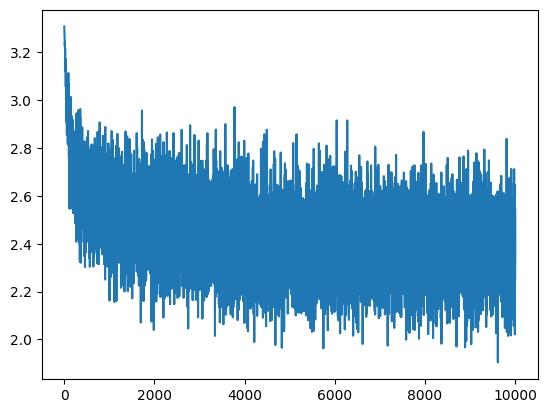

In [986]:
plt.plot(stepi, lossi)

In [987]:
def eval(X,Y):
    # evalualte loss on train sample
    xenc = C[X].view((-1, c_size*block_size))
    h = torch.tanh(xenc @ W1 + b1)
    logits = h @ W2 + b2
    return F.cross_entropy(logits, Y)


In [1088]:
# evalualte loss on train sample
print(eval(Xtr, Ytr))

tensor(2.1592, grad_fn=<NllLossBackward0>)


In [1089]:
# evalualte loss on dev sample
print(eval(Xdev, Ydev))

tensor(2.1745, grad_fn=<NllLossBackward0>)


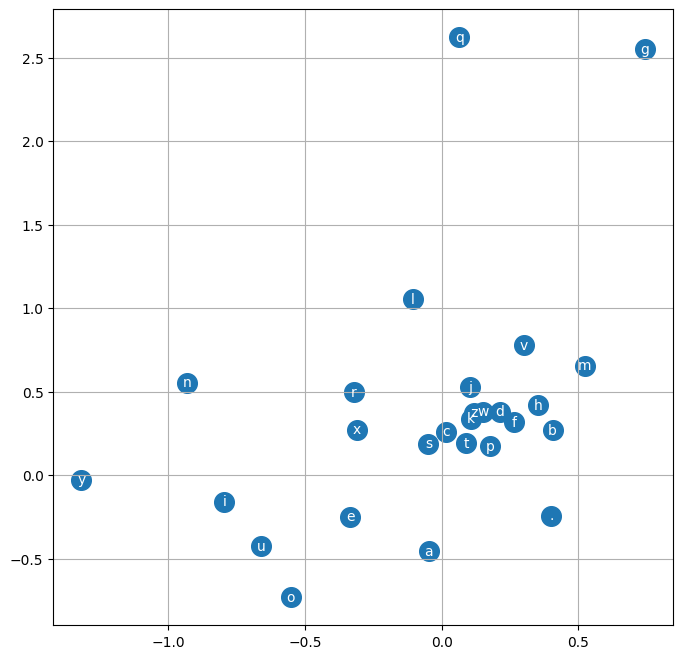

In [449]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data,s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')

In [1010]:
# evalualte loss on test sample
print(eval(Xtest, Ytest))

tensor(2.3608, grad_fn=<NllLossBackward0>)


In [230]:
ix

0

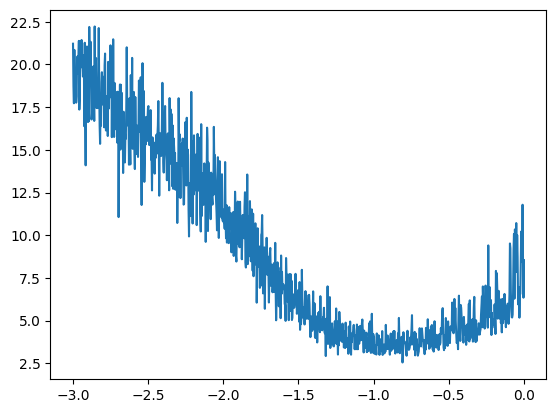

In [289]:
plt.plot(lri, lossi)

In [922]:
P[context[:2]]

tensor([[3.1192e-05, 1.3759e-01, 4.0767e-02, 4.8129e-02, 5.2745e-02, 4.7785e-02,
         1.3038e-02, 2.0898e-02, 2.7293e-02, 1.8465e-02, 7.5577e-02, 9.2452e-02,
         4.9064e-02, 7.9195e-02, 3.5777e-02, 1.2321e-02, 1.6095e-02, 2.9008e-03,
         5.1154e-02, 6.4130e-02, 4.0830e-02, 2.4641e-03, 1.1759e-02, 9.6070e-03,
         4.2109e-03, 1.6719e-02, 2.9008e-02],
        [3.1192e-05, 1.3759e-01, 4.0767e-02, 4.8129e-02, 5.2745e-02, 4.7785e-02,
         1.3038e-02, 2.0898e-02, 2.7293e-02, 1.8465e-02, 7.5577e-02, 9.2452e-02,
         4.9064e-02, 7.9195e-02, 3.5777e-02, 1.2321e-02, 1.6095e-02, 2.9008e-03,
         5.1154e-02, 6.4130e-02, 4.0830e-02, 2.4641e-03, 1.1759e-02, 9.6070e-03,
         4.2109e-03, 1.6719e-02, 2.9008e-02]])

In [925]:
logits

tensor([[-7.4414,  1.9809,  0.8409,  0.9619,  0.9919,  0.7857, -0.3243,  0.1218,
          0.3096, -0.0421,  1.4364,  1.5556,  0.7574,  1.5410,  0.5295, -0.5842,
         -0.1447, -1.8776,  0.9349,  1.2480,  0.7401, -2.1880, -0.6192, -0.7543,
         -1.5366, -0.2337,  0.3593]], grad_fn=<AddBackward0>)

In [932]:
P[context[-2], context[-1]]

tensor(3.1192e-05)

In [930]:
context

[0, 0, 0]

In [924]:
F.softmax(logits, dim=1).shape

torch.Size([1, 27])

In [937]:
P[context[-2], context[-1]]

tensor(3.1192e-05)

In [1091]:
# Sample from network
g = torch.Generator().manual_seed(2147483647)
for i in range(50):
    context = [0] * block_size
    out = ''
    ix=0
    while True:
        # Forward pass
        xenc = C[context].view((-1, c_size*block_size))
        h = torch.tanh(xenc @ W1 + b1)
        logits = h @ W2 + b2
        p =F.softmax(logits, dim=1)
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out += itos[ix]
        context = context[1:] + [ix]
        if(ix == 0):
            res.append(out)
            break
    print(out)

junide.
jakarie.
prosaywel.
makshir.
tolian.
juem.
kalinaa.
zamilena.
jedbyaine.
imbresson.
evy.
arten.
nveumarif.
demmericynsleigh.
ani.
core.
yae.
ockayda.
brine.
kolin.
wynin.
ana.
saravilanna.
shadion.
matta.
ilu.
reniel.
that.
jayreli.
isa.
dyn.
rujeani.
mah.
dawyan.
kha.
cramr.
jenh.
adorta.
malyn.
bal.
haur.
lavaroni.
themielya.
ath.
baston.
tavilitike.
salee.
marlen.
ema.
malenella.
